In [1]:
import numpy as np  
import pandas as pd 
import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

### Loading the Microsoft Stock Price data

- Download the Microsoft Stock Price Data from Year 2021 to 2024(current).
- The dataset has 7 columns which are Date, Open, High, Low, Close, Adj, Close and Volume.
- In this notebook, we will only use 'Close' price of the Microsoft Stock Price data.
- The prediction of closing price will be based on the historical closing prices.

https://finance.yahoo.com/quote/MSFT/history?period1=511056000&period2=1708560000&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true

In [2]:
msft_df = pd.read_csv('/kaggle/input/msft-2021-2024/MSFT (2021-2024).csv')
msft_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-01-04,222.529999,223.000000,214.809998,217.690002,211.605301,37130100
1,2021-01-05,217.259995,218.520004,215.699997,217.899994,211.809448,23823000
2,2021-01-06,212.169998,216.490005,211.940002,212.250000,206.317383,35930700
3,2021-01-07,214.039993,219.339996,213.710007,218.289993,212.188538,27694500
4,2021-01-08,218.679993,220.580002,217.029999,219.619995,213.481323,22956200


### Selecting columns 'Date' and 'Close'

In [3]:
msft_price_df = msft_df[['Date','Close']]
msft_price_df['Date'] = pd.to_datetime(msft_price_df['Date'])
msft_price_df.head() 

,Date,Close
0,2021-01-04,217.690002
1,2021-01-05,217.899994
2,2021-01-06,212.250000
3,2021-01-07,218.289993
4,2021-01-08,219.619995


### Visualizing the Closing Prices

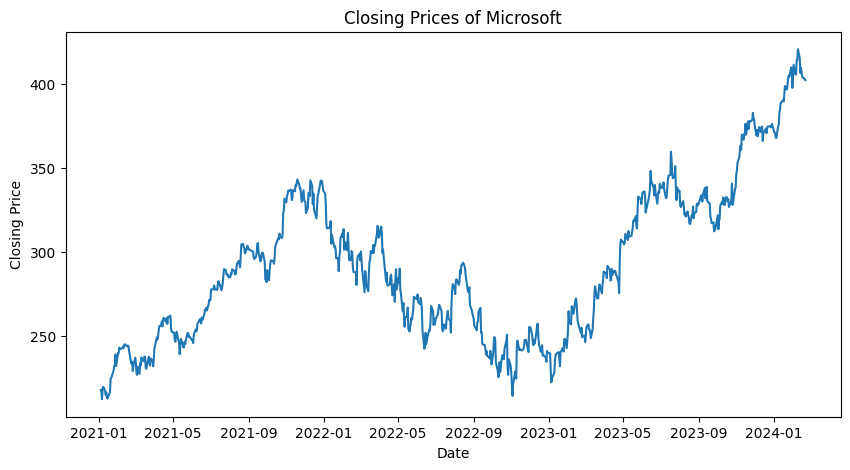

In [4]:
plt.rcParams['figure.figsize']=(10,5)
plt.plot(msft_price_df['Date'],msft_price_df['Close'])
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Closing Prices of Microsoft')
plt.show()

### Preparing the data to feed into LSTM: A Univariate Approach

- In this step, we have closing prices for last three days indicated by (close-i) where i =(1,2,3). Also,we have closing price on every 4th day and their corresponding dates.
- This step is important to ensure we have sufficient historical closing prices to predict the future closing prices.
- In the below table, we have taken a lookback period/window of three days to predict the target closing price on the 4th day.

In [5]:
def series_to_windowed_data(df,window,dropNA=True):
    
    cols, names = list(), list()
    
    cols.append(df['Date'].iloc[window:])
    names.append('Date')
    df.pop('Date')
    
    
    for i in range(window,0,-1):
        cols.append(df.shift(i))
        names += [f'Close-{i}' for col in df.columns]
        
        
    cols.append(df.iloc[window:])   
    names += [ 'Close' for col in  df.columns]
    
    agg = pd.concat(cols,axis=1)
    agg.columns = names
    
    if dropNA:
        agg.dropna(inplace=True)
    return agg

result = series_to_windowed_data(msft_price_df ,3)
result

,Date,Close-3,Close-2,Close-1,Close
3,2021-01-07,217.690002,217.899994,212.250000,218.289993
4,2021-01-08,217.899994,212.250000,218.289993,219.619995
5,2021-01-11,212.250000,218.289993,219.619995,217.490005
6,2021-01-12,218.289993,219.619995,217.490005,214.929993
7,2021-01-13,219.619995,217.490005,214.929993,216.339996
...,...,...,...,...,...
783,2024-02-14,420.549988,415.260010,406.320007,409.489990
784,2024-02-15,415.260010,406.320007,409.489990,406.559998
785,2024-02-16,406.320007,409.489990,406.559998,404.059998
786,2024-02-20,409.489990,406.559998,404.059998,402.790009


In [6]:
def prepare_data_for_LSTM(windowed_data):
    df_as_np = windowed_data.to_numpy() # Matrix
    
    dates = df_as_np[:,0]
    inputs = df_as_np[:,1:-1].reshape((len(dates)),3,1)
    target = df_as_np[:,-1]
    
    return dates,inputs.astype(np.float32),target.astype(np.float32)
dates,inputs,target =  prepare_data_for_LSTM(result)
 

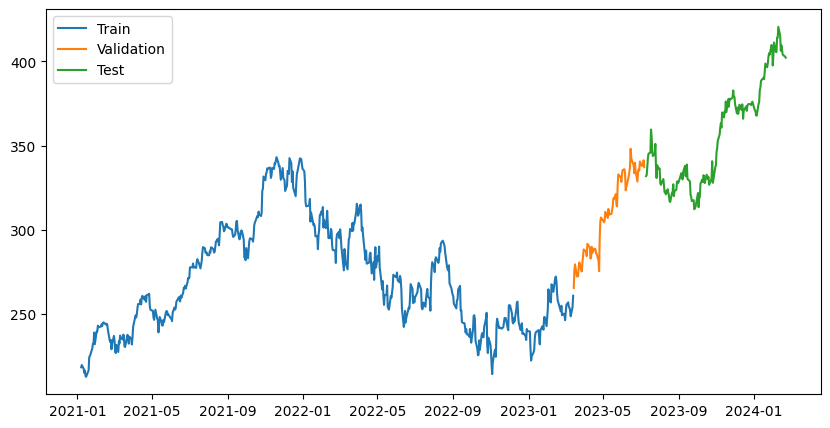

In [7]:
index_70 = int(len(dates)*0.7)
index_80 = int(len(dates)*0.8)

dates_train, inputs_train, target_train= dates[:index_70], inputs[:index_70], target[:index_70]
dates_val,inputs_val, target_val = dates[index_70:index_80], inputs[index_70:index_80], target[index_70:index_80]
dates_test,inputs_test,target_test = dates[index_80:], inputs[index_80:], target[index_80:]

plt.plot(dates_train,target_train)
plt.plot(dates_val,target_val)
plt.plot(dates_test,target_test)
plt.legend(['Train','Validation','Test'])
plt.show()


### Building a Neural Network to implement Long-Short-Term-Memory(LSTM)

- The metric used in the model to measure loss is Mean Squared Error.
- The model will run for 100 epochs.

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers


model = Sequential([layers.Input((3,1)),
            layers.LSTM(64),
            layers.Dense(32, activation = 'relu'),
            layers.Dense(32, activation = 'relu'),
            layers.Dense(1)
           ])
model.compile(loss = 'mse', optimizer = Adam(learning_rate = 0.001),
             metrics = ['mean_absolute_error'])

model.fit(inputs_train, target_train,validation_data= (inputs_val, target_val), epochs=100)

2024-02-23 03:36:23.620189: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-23 03:36:23.620319: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-23 03:36:23.786483: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Epoch 1/100
18/18 [==============================] - 3s 41ms/step - loss: 74133.8594 - mean_absolute_error: 270.4702 - val_loss: 95228.3125 - val_mean_absolute_error: 307.7132
Epoch 2/100
18/18 [==============================] - 0s 6ms/step - loss: 73383.3359 - mean_absolute_error: 269.0788 - val_loss: 94325.9141 - val_mean_absolute_error: 306.2428
Epoch 3/100
18/18 [==============================] - 0s 6ms/step - loss: 72301.3750 - mean_absolute_error: 267.0603 - val_loss: 92624.7656 - val_mean_absolute_error: 303.4519
Epoch 4/100
18/18 [==============================] - 0s 7ms/step - loss: 70194.4766 - mean_absolute_error: 263.0834 - val_loss: 89032.0234 - val_mean_absolute_error: 297.4727
Epoch 5/100
18/18 [==============================] - 0s 6ms/step - loss: 66267.6406 - mean_absolute_error: 255.5053 - val_loss: 83666.1484 - val_mean_absolute_error: 288.3138
Epoch 6/100
18/18 [==============================] - 0s 6ms/step - loss: 60580.7031 - mean_absolute_error: 244.0544 - val_lo

18/18 [==============================] - 1s 2ms/step


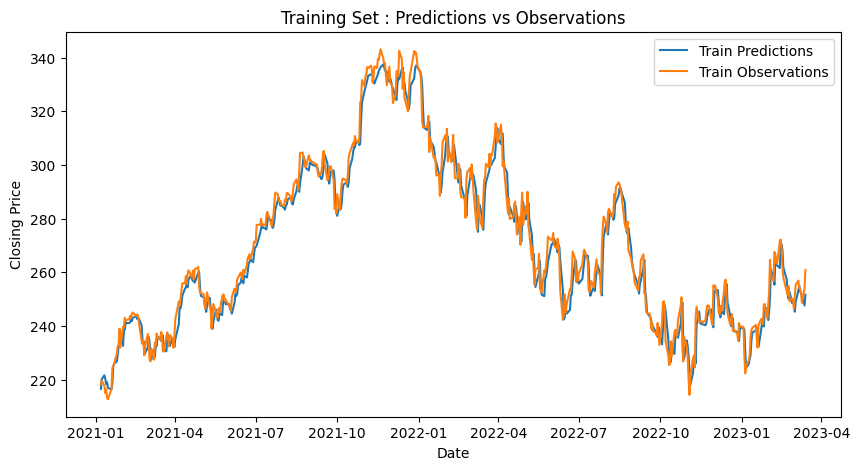

In [9]:
train_predictions = model.predict(inputs_train).flatten()

plt.plot(dates_train, train_predictions, label = 'Train Predictions')
plt.plot(dates_train, target_train, label = 'Train Observations')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Training Set : Predictions vs Observations')
plt.legend()
plt.show()

3/3 [==============================] - 0s 4ms/step


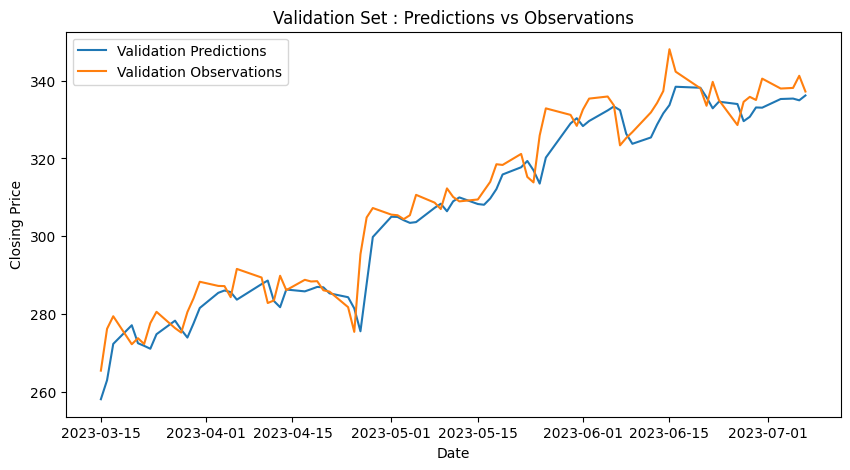

In [10]:
validation_predictions = model.predict(inputs_val).flatten()

plt.plot(dates_val, validation_predictions, label = 'Validation Predictions')
plt.plot(dates_val, target_val, label = 'Validation Observations')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Validation Set : Predictions vs Observations')
plt.legend()
plt.show()

5/5 [==============================] - 0s 3ms/step


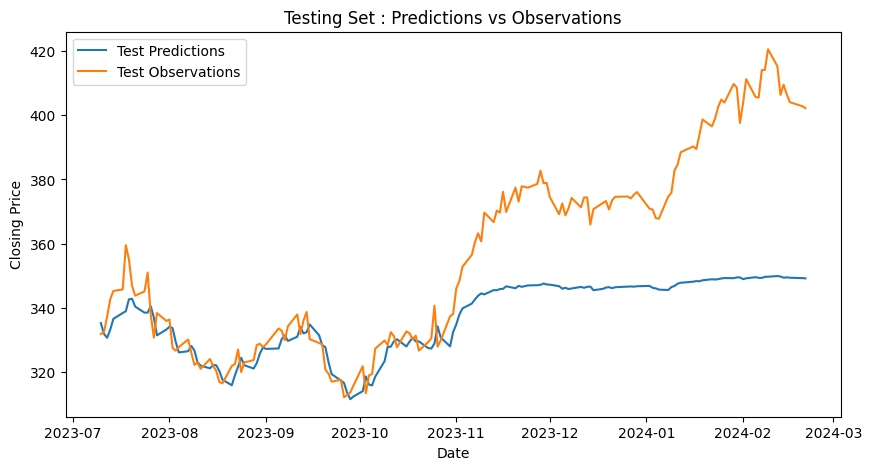

In [11]:
test_predictions = model.predict(inputs_test).flatten()

plt.plot(dates_test, test_predictions, label = 'Test Predictions')
plt.plot(dates_test, target_test, label = 'Test Observations')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Testing Set : Predictions vs Observations')
plt.legend()
plt.show()